# Deep Features Extraction

The records are imported in 1.2

## Collect Data

In [1]:
from sklearn.metrics import cohen_kappa_score, accuracy_score
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
#from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")




BATCH_SIZE=4

IMG_SIZE=224
historyfilename='model/history_model.json'
modelweights='model/model_weights.h5'

#The image names are found in the data-split folder
filename_train_covid='../Data-split/COVID/trainCT_COVID.txt'
filename_val_covid='../Data-split/COVID/valCT_COVID.txt'
filename_test_covid='../Data-split/COVID/testCT_COVID.txt'

filename_train_no_covid='../Data-split/NonCOVID/trainCT_NonCOVID.txt'
filename_val_no_covid='../Data-split/NonCOVID/valCT_NonCOVID.txt'
filename_test_no_covid='../Data-split/NonCOVID/testCT_NonCOVID.txt'


# In[5]:


path_covid='../Images-processed/CT_COVID/CT_COVID/'
path_non_covid='../Images-processed/CT_NonCOVID/CT_NonCOVID/'


# In[6]:



#prepare training data
with open(filename_train_covid) as f:
    covidimages_train_path = f.read().splitlines()

covidimages_train_path=[path_covid+s for s in covidimages_train_path]
covidclasses=[1]*len(covidimages_train_path)
print("Number of COVID images in train dataset is :"+ str(len(covidclasses)))

with open(filename_train_no_covid) as f:
    no_covidimages_train_path = f.read().splitlines()
non_covidimages_train_path=[path_non_covid+s for s in no_covidimages_train_path]
non_covidclasses=[0]*len(non_covidimages_train_path)
print("Number of Non COVID images in train dataset is :"+ str(len(non_covidclasses)))

trainpaths=covidimages_train_path+non_covidimages_train_path
Y_train=covidclasses+non_covidclasses

print("training samples :"+ str(len(Y_train)))


# In[7]:



#prepare val data
with open(filename_val_covid) as f:
    covidimages_val_path = f.read().splitlines()

covidimages_val_path=[path_covid+s for s in covidimages_val_path]
covidclasses=[1]*len(covidimages_val_path)
print("Number of COVID images in val dataset is :"+ str(len(covidclasses)))

with open(filename_val_no_covid) as f:
    no_covidimages_val_path = f.read().splitlines()
non_covidimages_val_path=[path_non_covid+s for s in no_covidimages_val_path]
non_covidclasses=[0]*len(non_covidimages_val_path)
print("Number of Non COVID images in val dataset is :"+ str(len(non_covidclasses)))

valpaths=covidimages_val_path+non_covidimages_val_path
Y_val=covidclasses+non_covidclasses

print("valing samples :"+ str(len(Y_val)))


# In[8]:



#prepare test data
with open(filename_test_covid) as f:
    covidimages_test_path = f.read().splitlines()

covidimages_test_path=[path_covid+s for s in covidimages_test_path]
covidclasses=[1]*len(covidimages_test_path)
print("Number of COVID images in test dataset is :"+ str(len(covidclasses)))

with open(filename_test_no_covid) as f:
    no_covidimages_test_path = f.read().splitlines()
non_covidimages_test_path=[path_non_covid+s for s in no_covidimages_test_path]
non_covidclasses=[0]*len(non_covidimages_test_path)
print("Number of Non COVID images in test dataset is :"+ str(len(non_covidclasses)))

testpaths=covidimages_test_path+non_covidimages_test_path
Y_test=covidclasses+non_covidclasses

print("testing samples :"+ str(len(Y_test)))


# In[9]:




def equalize_light(image, limit=2, grid=(16,16), gray=False):
    if (len(image.shape) == 2):
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        gray = True
    
    clahe = cv2.createCLAHE(clipLimit=limit, tileGridSize=grid)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))

    image = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    if gray: 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    return np.uint8(image)

def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x) #typically will be zero
    max_val = np.max(x) #typically will be 255
    x = (x-min_val) / (max_val-min_val)
    return x
def load_ben_color(path, sigmaX=10 ):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = equalize_light(image,3,(5,5))
    #image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    image=normalize(image)  
    return image



N = len(trainpaths)
X_train = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_path in enumerate(tqdm(trainpaths)):
    X_train[i, :, :, :] = load_ben_color(image_path,sigmaX=10)


# In[14]:


print(X_train.shape)


# In[15]:


N_val = len(valpaths)
X_val = np.empty((N_val, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_path in enumerate(tqdm(valpaths)):
    X_val[i, :, :, :] = load_ben_color(image_path,sigmaX=10)
print(X_val.shape)


# In[16]:


N_test = len(testpaths)
X_test = np.empty((N_test, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_path in enumerate(tqdm(testpaths)):
    X_test[i, :, :, :] = load_ben_color(image_path,sigmaX=10)
print(X_test.shape)


C:\Users\AliHaidar\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Number of COVID images in train dataset is :191
Number of Non COVID images in train dataset is :234
training samples :425
Number of COVID images in val dataset is :60
Number of Non COVID images in val dataset is :58
valing samples :118
Number of COVID images in test dataset is :98
Number of Non COVID images in test dataset is :105
testing samples :203


100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [00:05<00:00, 79.25it/s]


(425, 224, 224, 3)


100%|███████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 107.96it/s]


(118, 224, 224, 3)


100%|███████████████████████████████████████████████████████████████████████████████| 203/203 [00:01<00:00, 118.43it/s]


(203, 224, 224, 3)


In [2]:
X_train[0,:,:,:]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

## Import Extracted Features

In [2]:
import pickle

#with open("densenet121/extractedfeatures.pickle", "wb") as f:
#    pickle.dump((Train_Features,Train_Target,Val_Features,Val_Target,Test_Features,Test_Target,model,model_extracted), f)

with open("model/MondayDesneNet169/extractedfeatures.pickle", "rb") as f:
    Train_Features,Train_Target,Val_Features,Val_Target,Test_Features,Test_Target,model,model_extracted = pickle.load(f) 

# Significance Test
## Get the features into a dataframe

In [4]:
z=pd.DataFrame(Test_Features)
z['target']=Test_Target
z.head()

,0,1,2,3,4,5,6,7,8,9,...,1655,1656,1657,1658,1659,1660,1661,1662,1663,target
0,0.001649,0.001086,6.450953e-09,0.001037,0.000465,0.000872,0.002501,0.000091,0.000017,0.0,...,1.091209,0.027025,2.226795,0.568400,0.587277,0.606502,0.145341,0.175026,0.418009,1
1,0.000774,0.000774,0.000000e+00,0.000949,0.000648,0.002735,0.001101,0.000024,0.000040,0.0,...,0.728008,0.499429,2.522061,0.579054,0.748308,1.501107,1.309332,0.310400,1.054950,1
2,0.001329,0.001503,0.000000e+00,0.000972,0.000863,0.001286,0.002688,0.000061,0.000011,0.0,...,0.645433,0.000000,2.706715,0.445044,1.063933,0.773287,0.266251,0.187910,0.653035,1
3,0.000936,0.001369,0.000000e+00,0.000939,0.000661,0.002874,0.001335,0.000039,0.000020,0.0,...,0.906812,0.265181,2.089057,0.414063,1.441583,1.520676,0.808349,0.072189,1.048036,1
4,0.001749,0.001000,0.000000e+00,0.001059,0.000813,0.001496,0.002339,0.000042,0.000010,0.0,...,1.078483,0.000000,4.420591,0.490259,2.063996,0.067864,0.031631,0.039502,0.412068,1


## save the covid features to a dataframe

In [5]:
covid_feat=z.loc[z['target']==1]
covid_feat=covid_feat.drop(['target'],axis=1)
covid_feat=covid_feat.reset_index(drop=True)
covid_feat.describe()

,0,1,2,3,4,5,6,7,8,9,...,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663
count,98.000000,98.000000,9.800000e+01,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.0,...,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,0.001248,0.001319,2.524223e-08,0.000934,0.000666,0.001607,0.001607,0.000066,0.000018,0.0,...,3.312127,1.019331,0.235724,2.339088,1.437488,0.652957,0.987084,0.752131,0.506920,1.063404
std,0.000575,0.000484,1.444242e-07,0.000161,0.000330,0.000547,0.000575,0.000046,0.000010,0.0,...,2.422191,0.760601,0.510076,2.269572,1.523873,0.449443,0.871454,0.887263,0.493338,0.743516
min,0.000245,0.000515,0.000000e+00,0.000223,0.000084,0.000306,0.000237,0.000002,0.000000,0.0,...,0.000000,0.103857,0.000000,0.030984,0.000000,0.055024,0.000000,0.000000,0.001097,0.055187
25%,0.000796,0.000937,0.000000e+00,0.000854,0.000436,0.001226,0.001178,0.000028,0.000011,0.0,...,1.330120,0.499322,0.007664,0.848599,0.265296,0.264102,0.313944,0.157012,0.161307,0.494646
50%,0.001145,0.001240,0.000000e+00,0.000969,0.000625,0.001598,0.001621,0.000061,0.000019,0.0,...,2.715761,0.832277,0.063701,1.794734,0.638555,0.590388,0.676186,0.425348,0.327060,0.895540
75%,0.001705,0.001694,0.000000e+00,0.001033,0.000817,0.001982,0.002036,0.000092,0.000025,0.0,...,5.044714,1.250614,0.253263,3.389001,2.298876,0.876697,1.460955,0.920608,0.776803,1.537537
max,0.002566,0.002654,1.037154e-06,0.001229,0.001891,0.002874,0.002992,0.000201,0.000046,0.0,...,8.811655,3.901281,4.354335,16.258263,7.137276,2.063996,3.580933,4.336430,2.927922,3.106317


## Save the non covid features

In [36]:
non_covid_feat=z.loc[z['target']==0]
non_covid_feat=non_covid_feat.drop(['target'],axis=1)
non_covid_feat=non_covid_feat.reset_index(drop=True)
non_covid_feat=non_covid_feat.head(98)#selected the first 98 to make sure that the number of samples are equal
non_covid_feat.describe()

,0,1,2,3,4,5,6,7,8,9,...,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663
count,98.000000,98.000000,9.800000e+01,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.0,...,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,0.000850,0.001303,2.075173e-08,0.000965,0.000609,0.002100,0.000964,0.000056,0.000030,0.0,...,0.947760,0.919676,1.033134,1.913849,1.035403,1.031385,0.795198,0.906766,0.917614,1.240114
std,0.000397,0.000308,1.285661e-07,0.000102,0.000164,0.000407,0.000534,0.000026,0.000007,0.0,...,1.251250,0.493257,0.851603,0.848680,1.013819,0.419771,0.509863,0.628759,0.701072,0.773064
min,0.000330,0.000748,0.000000e+00,0.000651,0.000244,0.000741,0.000208,0.000018,0.000007,0.0,...,0.000000,0.056769,0.000000,0.081618,0.000000,0.061087,0.070033,0.076234,0.004901,0.141477
25%,0.000567,0.001113,0.000000e+00,0.000923,0.000495,0.001824,0.000532,0.000039,0.000026,0.0,...,0.153479,0.522047,0.438912,1.451328,0.339936,0.742516,0.428039,0.411257,0.408978,0.665186
50%,0.000791,0.001258,0.000000e+00,0.000982,0.000620,0.002169,0.000838,0.000051,0.000030,0.0,...,0.442188,0.888801,0.780638,1.822992,0.729092,1.087426,0.667905,0.787810,0.691819,1.029578
75%,0.000937,0.001431,0.000000e+00,0.001034,0.000701,0.002355,0.001286,0.000067,0.000033,0.0,...,1.140306,1.166816,1.395865,2.157593,1.395308,1.235317,1.011737,1.193980,1.346892,1.663054
max,0.002869,0.002289,1.109712e-06,0.001151,0.001242,0.003092,0.002319,0.000153,0.000048,0.0,...,6.081854,2.718112,3.791058,4.999496,4.754226,2.390061,2.560513,3.218781,3.128746,3.667073


In [26]:
non_covid_feat.shape

(98, 1664)

## Apply t-test for each set of features

In [31]:
from scipy.stats import f_oneway,ttest_ind,ttest_rel

In [75]:
count_significance = 0
col_sig=[]
count_no_significance= 0
for col in columns:
    data1=covid_feat[col].tolist()
    data2=non_covid_feat[col].tolist()
    stat, p = ttest_ind(data1, data2)
    if p > 0.05:
        print('Probably the same distribution')
        count_no_significance=count_no_significance+1
    else:
        print('Probably different distributions')
        col_sig.append(col)
        count_significance=count_significance+1



Probably different distributions
Probably the same distribution
Probably the same distribution
Probably the same distribution
Probably the same distribution
Probably different distributions
Probably different distributions
Probably the same distribution
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably the same distribution
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably the same distribution
Probably the same distribution
Probably different distributions
Probably the same distribution
Probably different distribut

Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably the same distribution
Probably different distributions
Probably the same distribution
Probably different distributions
Probably different distributions
Probably the same distribution
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably the same distribution
Probably the same distribution
Probably the same distribution
Probably different distributions
Probably the same distribution
Probably the same distribution
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distrib

Probably the same distribution
Probably different distributions
Probably the same distribution
Probably different distributions
Probably different distributions
Probably different distributions
Probably the same distribution
Probably the same distribution
Probably the same distribution
Probably the same distribution
Probably the same distribution
Probably different distributions
Probably different distributions
Probably the same distribution
Probably the same distribution
Probably the same distribution
Probably the same distribution
Probably the same distribution
Probably different distributions
Probably the same distribution
Probably different distributions
Probably the same distribution
Probably different distributions
Probably different distributions
Probably different distributions
Probably the same distribution
Probably different distributions
Probably different distributions
Probably different distributions
Probably the same distribution
Probably the same distribution
Probably th

Probably different distributions
Probably different distributions
Probably the same distribution
Probably different distributions
Probably different distributions
Probably different distributions
Probably the same distribution
Probably the same distribution
Probably different distributions
Probably different distributions
Probably the same distribution
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably the same distribution
Probably different distributions
Probably the same distribution
Probably different distributions
Probably different distributions
Probably the same distribution
Probably different distributions
Probably different distributions
Probably the same distribution
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distributions
Probably different distrib

In [76]:
print(count_significance)

1203


In [38]:
1203/1664 

0.7229567307692307

## Analyse important features in RF

In [96]:
## RF important features
importances = rf.feature_importances_
columns=covid_feat.columns.tolist()
di={'column': columns, 'importance':importances}
featimp=pd.DataFrame(di)
featimp = featimp.sort_values(by ='importance',ascending=False)# sort the dataframe

In [114]:
featimp.head(10)

,column,importance
984,984,0.014081
120,120,0.010435
557,557,0.010210
1563,1563,0.009571
1433,1433,0.009345
1389,1389,0.009126
404,404,0.008559
1218,1218,0.007251
49,49,0.006631
847,847,0.006321


### top 50 features

In [109]:
d=featimp['column'].tolist()[:50]#get the top 30 features
#check the ones that are not in significant columns
for i in d: 
    if i not in col_sig:
        print(i)

### top 100

In [105]:
d=featimp['column'].tolist()[:100]#get the top 30 features
#check the ones that are not in significant columns
for i in d: 
    if i not in col_sig:
        print(i)

1288
1472
1128
1008


In [107]:
d=featimp['column'].tolist()[:200]#get the top 30 features
#check the ones that are not in significant columns
for i in d: 
    if i not in col_sig:
        print(i)

1288
1472
1128
1008
184
1158
653
1414
3
1395
341
1294
1180
1195
1023
1121
719
987
1392
1551
80


In [108]:
21/200

0.105

Example

In [ ]:
# Example of the Analysis of Variance Test
from scipy.stats import f_oneway
data1 = [0.873, 2.817, 0.121, -0.945, -0.055, -1.436, 0.360, -1.478, -1.637, -1.869]
data2 = [1.142, -0.432, -0.938, -0.729, -0.846, -0.157, 0.500, 1.183, -1.075, -0.169]
data3 = [-0.208, 0.696, 0.928, -1.148, -0.213, 0.229, 0.137, 0.269, -0.870, -1.204]
stat, p = f_oneway(data1, data2, data3)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

### Boxplot features

In [212]:
#top 10 features
top_10=featimp['column'].tolist()[:10]

In [213]:
z=pd.DataFrame(Test_Features)
z['target']=Test_Target

In [214]:
top_10.append('target')

In [215]:
def label_cov(row):
   if row['target'] == 1 :
      return 'Covid'
   if row['target']==0:
      return 'Non-Covid'
   return 'Other'

In [216]:
a=z[top_10]

In [217]:
top_10

[984, 120, 557, 1563, 1433, 1389, 404, 1218, 49, 847, 'target']

In [218]:
a['Class'] = a.apply (lambda row: label_cov(row), axis=1)

In [219]:
a=a.drop(['target'],axis=1)

In [220]:
a.head()

,984,120,557,1563,1433,1389,404,1218,49,847,Class
0,0.582984,0.000040,0.001805,0.255897,1.650878,0.187005,0.000026,0.765025,0.000437,0.000683,Covid
1,0.510031,0.000057,0.001322,0.422787,0.142306,0.136975,0.000077,0.106920,0.000952,0.000576,Covid
2,0.040981,0.000007,0.001426,0.038129,3.387636,0.826816,0.000036,2.238127,0.000521,0.000565,Covid
3,0.315843,0.000039,0.001582,0.210463,0.619188,0.384415,0.000062,1.194632,0.000862,0.000706,Covid
4,0.007642,0.000002,0.000926,0.146832,2.504241,0.969396,0.000007,0.883134,0.000258,0.000659,Covid


In [224]:
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [268]:
fig.gca().get_title()

''

Text(0.5, 0.98, '')

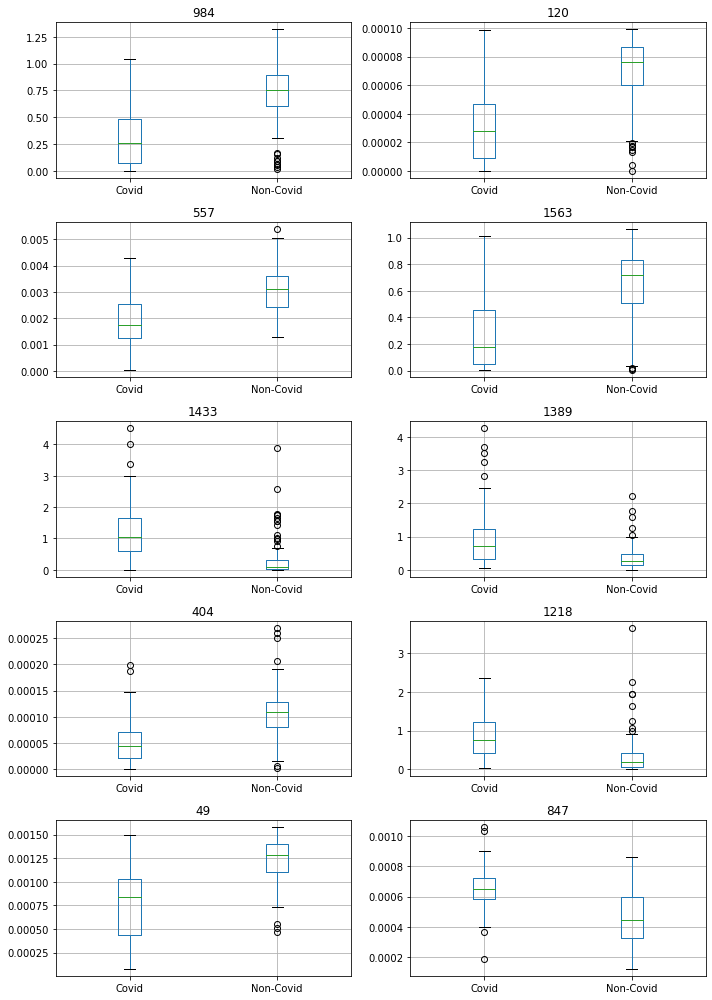

In [281]:
fig,ax = plt.subplots(5, 2, figsize=(10, 14))
top_10=featimp['column'].tolist()[:10]
count=0
for i in [0,1,2,3,4]:
    for j in [0,1]:
        if count ==10:
            break;
        a.boxplot(top_10[count],'Class', ax=ax[i][j])
        ax[i][j].set_xlabel(None)
        count=count+1
        
#fig.delaxes(ax[3][1])
#fig.delaxes(ax[3][2])
fig.tight_layout()
plt.suptitle('') 


[Text(0, 0, 'data1'), Text(0, 0, 'data2')]

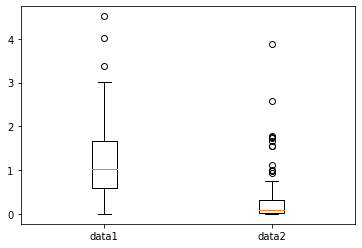

In [196]:
#example
col=1433
data1=covid_feat[col].tolist()
data2=non_covid_feat[col].tolist()
my_dict = {'data1': data1, 'data2': data2}

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())

# Ensembles

In [43]:
from sklearn.metrics import confusion_matrix
def measure_per(y_val,preds,num_classes):
    print(accuracy_score(y_val,preds))
    print(cohen_kappa_score(y_val,preds))

    
    df_cm = pd.DataFrame(cm, range(num_classes),
                              range(num_classes))
    print(df_cm)

In [44]:
num_classes=2
# Creating a function to report confusion metrics
def confusion_metrics (truvalues,predictions):
# save confusion matrix and slice into four pieces
    conf_matrix = confusion_matrix(truvalues, predictions)
    df_cm = pd.DataFrame(conf_matrix, range(num_classes),
                              range(num_classes))
    print(df_cm)
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

## Relaod Models

In [39]:
import pickle

In [40]:
#reload xgboost
with open("Reportedmodels/bestXGBoostmodel.pickle", "rb") as f:
    xgb = pickle.load(f) 

with open("Reportedmodels/bestadaboostmodel.pickle", "rb") as f:
    adaboost = pickle.load(f) 

with open("Reportedmodels/bestbdtmodel.pickle", "rb") as f:
    bdt = pickle.load(f) 
    
with open("Reportedmodels/bestdartmmodel.pickle", "rb") as f:
    dart = pickle.load(f) 

with open("Reportedmodels/bestlightgbmmodel.pickle", "rb") as f:
    lgb = pickle.load(f) 

with open("Reportedmodels/bestRFmodel.pickle", "rb") as f:
    rf = pickle.load(f) 
    

## Check acc again

### XGBoost

In [41]:
from xgboost import XGBClassifier,XGBRegressor

preds_xgb = xgb.predict(Test_Features)

from sklearn.metrics import accuracy_score,f1_score,roc_curve,auc
fpr, tpr, thresholds = roc_curve(Y_test, xgb.predict_proba(Test_Features)[:,1])
print("AUC: " + str(auc(fpr, tpr)))

AUC: 0.9033041788143829


In [45]:
confusion_metrics(Y_test,preds_xgb)

    0   1
0  91  14
1  13  85
True Positives: 85
True Negatives: 91
False Positives: 14
False Negatives: 13
--------------------------------------------------
Accuracy: 0.87
Mis-Classification: 0.13
Sensitivity: 0.87
Specificity: 0.87
Precision: 0.87
f_1 Score: 0.87


### RF

In [46]:
from sklearn.ensemble import RandomForestClassifier

preds_rf = rf.predict(Test_Features)

fpr, tpr, thresholds = roc_curve(Y_test, rf.predict_proba(Test_Features)[:,1])
print("AUC: " + str(auc(fpr, tpr)))

AUC: 0.9011175898931001


In [47]:
confusion_metrics(Y_test,preds_rf)

    0   1
0  89  16
1  10  88
True Positives: 88
True Negatives: 89
False Positives: 16
False Negatives: 10
--------------------------------------------------
Accuracy: 0.87
Mis-Classification: 0.13
Sensitivity: 0.9
Specificity: 0.85
Precision: 0.85
f_1 Score: 0.87


### Bagging Decision Tree

In [48]:
from sklearn.tree import DecisionTreeClassifier

preds_bdt = bdt.predict(Test_Features)

fpr, tpr, thresholds = roc_curve(Y_test, bdt.predict_proba(Test_Features)[:,1])
print("AUC: " + str(auc(fpr, tpr)))

AUC: 0.9015549076773567


In [49]:
confusion_metrics(Y_test,preds_bdt)

    0   1
0  86  19
1  11  87
True Positives: 87
True Negatives: 86
False Positives: 19
False Negatives: 11
--------------------------------------------------
Accuracy: 0.85
Mis-Classification: 0.15
Sensitivity: 0.89
Specificity: 0.82
Precision: 0.82
f_1 Score: 0.85


### Adaboost

In [50]:
from sklearn.ensemble import AdaBoostClassifier


preds_adaboost = adaboost.predict(Test_Features)

fpr, tpr, thresholds = roc_curve(Y_test, adaboost.predict_proba(Test_Features)[:,1])
print("AUC: " + str(auc(fpr, tpr)))

AUC: 0.8350826044703596


In [51]:
confusion_metrics(Y_test,preds_adaboost)

    0   1
0  84  21
1  36  62
True Positives: 62
True Negatives: 84
False Positives: 21
False Negatives: 36
--------------------------------------------------
Accuracy: 0.72
Mis-Classification: 0.28
Sensitivity: 0.63
Specificity: 0.8
Precision: 0.8
f_1 Score: 0.71


### GBDT

In [52]:
import lightgbm

preds_gbdt=lgb.predict(Test_Features)

fpr, tpr, thresholds = roc_curve(Y_test, preds_gbdt)
print("AUC: " + str(auc(fpr, tpr)))

AUC: 0.9023323615160349


In [53]:
confusion_metrics(Y_test,np.round(preds_gbdt))

    0   1
0  90  15
1  18  80
True Positives: 80
True Negatives: 90
False Positives: 15
False Negatives: 18
--------------------------------------------------
Accuracy: 0.84
Mis-Classification: 0.16
Sensitivity: 0.82
Specificity: 0.86
Precision: 0.86
f_1 Score: 0.84


### Dart

In [54]:
import lightgbm

preds_dart=dart.predict(Test_Features)

fpr, tpr, thresholds = roc_curve(Y_test, preds_dart)
print("AUC: " + str(auc(fpr, tpr)))

AUC: 0.897181729834791


In [55]:
confusion_metrics(Y_test,np.round(preds_dart))

    0   1
0  93  12
1  15  83
True Positives: 83
True Negatives: 93
False Positives: 12
False Negatives: 15
--------------------------------------------------
Accuracy: 0.87
Mis-Classification: 0.13
Sensitivity: 0.85
Specificity: 0.89
Precision: 0.89
f_1 Score: 0.87


# Check Combinations

In [40]:
paths=[]
for i, image_path in enumerate(tqdm(testpaths)):
    paths.append(image_path)

100%|████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 183461.26it/s]


In [46]:
import pandas as pd

di={'paths':paths,'actual':Y_test,'DenseNet':np.round(np.squeeze(preds)),'preds_xgboost':preds_xgb,'preds_rf':preds_rf,
   'preds_bdt':preds_bdt,'preds_adaboost':preds_adaboost,'preds_gbdt':np.round(preds_gbdt),'preds_dart':np.round(preds_dart)}

df=pd.DataFrame(di)

In [49]:
df.head()

,paths,actual,DenseNet,preds_xgboost,preds_rf,preds_bdt,preds_adaboost,preds_gbdt,preds_dart,thes
0,../Images-processed/CT_COVID/CT_COVID/2020.03....,1,1.0,1,1,1,1,1.0,1.0,7.0
1,../Images-processed/CT_COVID/CT_COVID/2020.03....,1,0.0,1,1,1,0,1.0,0.0,4.0
2,../Images-processed/CT_COVID/CT_COVID/2020.03....,1,1.0,1,1,1,1,1.0,1.0,7.0
3,../Images-processed/CT_COVID/CT_COVID/2020.03....,1,1.0,1,1,1,1,1.0,1.0,7.0
4,../Images-processed/CT_COVID/CT_COVID/2020.03....,1,1.0,1,1,1,1,1.0,1.0,7.0


In [48]:
df['thes'] = df['DenseNet'] + df['preds_xgboost'] + df['preds_rf']+df['preds_bdt'] + df['preds_adaboost'] + df['preds_gbdt']+ df['preds_dart']

In [50]:
df.to_csv('Results.csv',index=False)

6 images were misclassified by all the models

In [52]:
6/105

0.05714285714285714

# Cluster

In [ ]:
# import KMeans
from sklearn.cluster import KMeans

In [ ]:
# create kmeans object
kmeans = KMeans(n_clusters=3)
# fit kmeans object to data
kmeans.fit(Train_Features)
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)

In [ ]:
y_km = kmeans.fit_predict(Train_Features)

In [ ]:
y_km

In [ ]:
s = kmeans.fit_predict(Test_Features)

In [ ]:
print(s)

In [ ]:
np.round(preds_dart)